In [186]:
import pandas as pd
import scanpy as sc
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [187]:
df = pd.read_csv(f'not_outliers.csv', sep=',')
# df = pd.read_csv(f'small.csv', sep=',')

In [188]:
labels = pd.read_csv(f'labels.csv', sep=',').values[:, 1]

In [189]:
countries = pd.read_csv(f'country.csv', sep=',').values

In [190]:
country = dict(zip(countries[:, 0], countries[:, 1]))

In [192]:
df.head()
print(len(df))

999626


In [193]:
len(np.unique(df['nationality'].values))

15

In [194]:
for i in np.unique(df['nationality'].values):
    print(country[i])
    idx_country = np.where(df['nationality'].values == i)[0]
    print(len(idx_country))

Virgin Islands 
1
Cabo Verde
225544
Central African Republic
19879
Indonesia
228574
Japan
154348
Mauritania
19
Namibia
164430
Netherlands
96814
Marshall Islands
7245
Peru
769
Romania
217
Serbia
55
Sweden
52070
Isle of Man
47261
Tanzania
2400


In [195]:
cif_i = np.where(df.columns == 'cif')[0]
category_i = np.where(df.columns == 'category')[0]
nationality_i = np.where(df.columns == 'nationality')[0]
ispep_i = np.where(df.columns == 'is_pep')[0]

In [196]:
features = list(df.columns)

In [257]:
features = np.array([
 'turnover',
 'transaction_count',
 'io_ratio',
 'age',
    'is_pep',
 'inactive_days_average',
 'inactive_days_max',
 'n_of_accounts',
 'distinct_counterparties',
 'channel_risk',
 'atm_withdrawal',
 'atm_deposit'])

In [258]:
len(np.where(df['is_pep'] == 1)[0])

6850

In [259]:
X_core = df[features].values

In [260]:
np.unique(df['nationality'].values)

array([ 24.,  32.,  33.,  82.,  90., 113., 123., 125., 133., 138., 145.,
       151., 166., 186., 187.])

In [261]:
idx = np.where(df['category'].values == 0)[0]
idx = idx[np.where(df['is_pep'].values[idx] == 0)[0]]
idx = idx[np.where(df['nationality'].values[idx] == 125.)[0]]
print(len(idx))

67067


In [262]:
idx = np.where(labels == 1)[0]
print(len(idx))

17109


In [263]:
import random
idx1 = np.where(labels == 1)[0]
idx0 = random.sample(list(np.where(labels == 0)[0]), len(idx1))
print(len(idx0))
idx = np.concatenate([idx0, idx1])

17109


In [265]:
X_core = df[features].values[idx, :]
Xm = np.mean(X_core, axis=0)
Xs = np.std(X_core, axis=0)
Xs[Xs < 1] = 1
X = (X_core - Xm)/Xs
np.std(X, axis=0)

adata = sc.AnnData(X)
adata.var_names = features

adata.obs['category'] = df['category'].values[idx]
adata.obs['nationality'] = df['nationality'].values[idx]
adata.obs['is_pep'] = df['is_pep'].values[idx]
adata.obs['labels'] = labels[idx]

sc.pp.neighbors(adata, n_neighbors=25)

sc.tl.umap(adata)

sc.tl.louvain(adata, resolution=0.99)

In [266]:
louvain = np.array(adata.obs['louvain'])
suspicios = dict(zip(np.unique(louvain), [0]*len(np.unique(louvain))))
cat_count = dict(zip(np.unique(louvain), [0]*len(np.unique(louvain))))
for il in np.unique(louvain):
    idx_lo = np.where(louvain == il)[0]
    suspicios[il] = len(np.where(adata.obs['labels'][idx_lo] == 1)[0]) / len(adata.obs['labels'][idx_lo])
    cat_count[il] = len(np.where(adata.obs['category'][idx_lo] == 0)[0])
    
for k in suspicios:
    if suspicios[k] > 0.6:
        print(k, f"{suspicios[k]:.2f}")

14 0.78
20 0.68
4 0.66


In [268]:
cat_count

{'0': 2532,
 '1': 2410,
 '10': 1441,
 '11': 1435,
 '12': 18,
 '13': 1275,
 '14': 1102,
 '15': 1228,
 '16': 993,
 '17': 994,
 '18': 441,
 '19': 837,
 '2': 9,
 '20': 798,
 '21': 5,
 '22': 2,
 '23': 7,
 '24': 2,
 '25': 8,
 '3': 2027,
 '4': 1765,
 '5': 1747,
 '6': 1742,
 '7': 7,
 '8': 1717,
 '9': 1451}

In [274]:
louvain_special = np.copy(louvain)
for i, u in enumerate(louvain_special):
    if (suspicios[u] <= 0.6):
        louvain_special[i] = '-1'

In [276]:
adata.obs['louvain_special'] = [str(s) for s in louvain_special]
adata.obs['category'] = [str(s) for s in df['category'].values[idx]]

sc.pl.umap(adata, color=['louvain_special', 'category'])
sc.pl.umap(adata, color=['category', 'nationality', 'is_pep', 'labels'])

... storing 'category' as categorical
... storing 'louvain_special' as categorical


In [273]:
df_adata = pd.DataFrame(X_core, columns=features)
df_adata['louvain'] = np.array(adata.obs['louvain'])
df_adata.groupby('louvain').mean()

turnover  transaction_count  io_ratio        age    is_pep  \
louvain                                                                   
0        2.311458e+06          18.729858  0.346148  51.588073  0.005924   
1        2.667353e+06          19.165145  0.385759  34.943983  0.009129   
10       2.456378e+06           1.657183  0.049283  41.988897  0.004858   
11       2.074064e+06           2.929617  0.336982  46.599303  0.006272   
12       3.537812e+07          31.045066  0.456063   0.200466  0.000000   
13       3.290409e+06          79.490196  0.349018  44.782745  0.007059   
14       1.018672e+07         326.588374  0.398874  38.862529  0.006284   
15       3.181917e+06           2.617264  0.320750  45.719055  0.011401   
16       6.040439e+06           1.236199  0.383303  41.651584  0.006335   
17       2.250573e+06           1.360161  0.073910  43.724346  0.010060   
18       1.381380e+07           1.134983  0.370032  22.767154  0.001125   
19       2.701770e+06           1.289128  0.994305  44.888889  0.004779   
2        3.526568e+08          36.252676  0.528938   0.099581  0.000465   
20       3.259366e+06           1.290727  0.989829  46.096491  0.008772   
21       2.683667e+07           2.399618  0.395610   0.122371  0.000000   
22       2.347205e+07           2.070664  0.396599   0.064240  0.000000   
23       1.824072e+08           2.024070  0.034505   0.437637  0.000000   
24       3.268794e+07           1.494457  0.991796   0.057650  0.000000   
25       5.618235e+07          25.945946  0.475815   0.310811  0.000000   
3        2.537873e+06           3.215590  0.215598  42.701529  0.006413   
4        3.790734e+06         124.845892  0.367460  47.326346  0.004533   
5        2.657499e+06          91.228964  0.347202  40.728678  0.007441   
6        2.180114e+06          11.004592  0.293224  62.056831  0.004592   
7        5.671738e+07          46.666475  0.481872   0.043628  0.000000   
8        2.181852e+06           1.995341  0.341180  44.072801  0.006407   
9        4.994204e+06          27.877970  0.347971  42.015414  0.008992   

         inactive_days_average  inactive_days_max  n_of_accounts  \
louvain                                                            
0                    16.800509          74.347946       2.000000   
1                    19.733332          98.913693       1.000000   
10                   55.119535          62.406662       1.000000   
11                   52.433261          70.691289       3.029965   
12                   43.404942         113.744367       3.038850   
13                    4.754424          95.709020       3.007059   
14                    0.630558          91.723488       1.839749   
15                   72.759503         176.029316       3.048860   
16                  171.784851         353.966516       1.908597   
17                   88.318773          88.820926       2.000000   
18                  165.907008         167.266592       1.752531   
19                   58.725448          80.720430       2.000000   
2                    20.337292          86.483481       2.000465   
20                   59.888797          71.482456       1.000000   
21                   80.028757         198.640535       2.000000   
22                   88.580792         208.788009       1.000000   
23                   64.033435          82.549234       1.210066   
24                   62.299645          84.618625       1.000000   
25                   29.988216          95.510811       4.024324   
3                    50.232329         139.119388       2.000000   
4                     1.839445          93.050425       1.000000   
5                     3.412124          92.862049       2.000572   
6                    27.430138          84.544202       1.000000   
7                    16.003737          91.867968       1.000574   
8                    85.924782         197.946418       1.000000   
9                    36.284213          99.845215       4.321130   

       

In [96]:
idx_lo = np.where(louvain == '15')[0]

In [238]:
df_adata.groupby('louvain').mean()

turnover  transaction_count  io_ratio        age  \
louvain                                                         
0        2.607729e+06          83.277385  0.348249  40.812721   
1        2.761979e+06           4.437946  0.341713  45.966239   
10       2.865964e+06         100.544285  0.349892  43.303558   
11       4.241622e+07          27.980213  0.464064   0.193303   
12       2.769097e+06           5.781250  0.437649  40.348558   
13       1.867773e+06          37.492168  0.355216  63.833471   
14       1.611915e+06          25.831471  0.318752  45.670391   
15       2.981516e+06           1.336914  0.992985  45.230469   
16       2.538351e+06           1.355036  0.324127  46.378433   
17       1.221814e+07           1.294178  0.395514  23.692543   
18       3.553447e+06           4.050936  0.369399  44.601871   
19       2.042479e+06           1.301176  0.066314  42.075294   
2        2.400887e+06          80.961237  0.357508  37.737978   
20       2.417352e+07          25.519139  0.431234  18.291866   
21       2.448332e+07          86.680774  0.479346   0.059250   
22       2.819899e+06           1.277992  0.994166  46.217503   
23       3.835405e+06           1.229097  0.294565  45.127090   
24       1.444194e+09          21.962838  0.397703   1.109797   
25       4.491695e+06           1.064327  0.134503  39.752437   
26       3.390576e+07           1.463074  0.747217   0.357285   
27       2.719615e+07           1.212575  0.492365   0.000000   
3        2.279404e+06           2.604009  0.335559  42.726436   
4        2.457683e+07          40.241512  0.420318   0.025192   
5        2.709913e+06          15.390904  0.306539  61.524467   
6        2.048377e+06           2.685564  0.191546  38.293396   
7        2.631751e+07           3.955952  0.489220   0.069048   
8        8.651535e+06         279.044458  0.393795  41.457107   
9        2.000084e+06           1.888435  0.011571  46.922449   

         inactive_days_average  inactive_days_max  n_of_accounts  \
louvain                                                            
0                     3.873454          91.367049       2.000442   
1                    41.289496         104.292915       3.000476   
10                    3.492831          93.547313       3.044663   
11                   39.688455         107.968037       3.014460   
12                   28.773510          72.026442       1.000000   
13                   11.250783          91.241550       1.000000   
14                   34.600959          99.204842       4.007449   
15                   65.517900          83.566406       1.000000   
16                  112.844629         227.435402       1.000000   
17                  159.725271         326.504597       2.312564   
18                   52.918212         189.316008       1.000000   
19                  102.140741         102.636471       1.000000   
2                     4.520510          96.729637       1.000000   
20                   36.285359         100.968900       4.671053   
21                    3.390822          90.960097       1.000000   
22                   64.608970          82.268983       2.000000   
23                  110.027258         110.533445       3.096990   
24                   36.264003         101.812500       1.724662   
25                  188.725575         189.251462       1.927875   
26                   70.282595          79.838323       2.000000   
27                  101.372365         101.880240       1.000000   
3                    78.677947         195.749729       1.997833   
4                    20.451944          97.908543       2.000000   
5                    21.898037          88.744387       2.000000   
6                    39.668866          61.890707       2.000000   
7                    47.605446         118.697024       1.000000   
8                     0.838779          92.039449       1.587977   
9                    35.673442          64.570748       1.000000   

         distinct_cou

In [121]:
df_adata.groupby('louvain').mean().reset_index(False).iloc[[16,26]]


louvain      turnover  transaction_count  io_ratio        age  \
16      23  1.752133e+06           1.378523  0.994273  46.112752   
26      32  1.943586e+07           1.514706  0.996144   0.000000   

    inactive_days_average  inactive_days_max  n_of_accounts  \
16              42.091128          66.954362            1.0   
26              46.378294          61.952941            1.0   

    distinct_counterparties  channel_risk  atm_withdrawal  atm_deposit  
16                 1.029530      0.260038   106047.064523    16.125744  
26                 1.085294      0.365029   481366.161559   513.725499

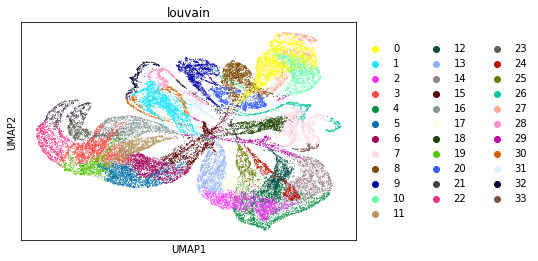

In [105]:
sc.pl.umap(adata, color=['louvain'])

In [106]:
sc.pl.umap(adata, color=['louvain', 'category', 'nationality', 'is_pep', 'labels'])

In [123]:
suspicios

{'0': 0.4173354735152488,
 '1': 0.38173652694610777,
 '10': 0.43935926773455375,
 '11': 0.5599356395816573,
 '12': 0.5280259951259139,
 '13': 0.6356968215158925,
 '14': 0.49212924606462305,
 '15': 0.7806122448979592,
 '16': 0.5111301369863014,
 '17': 0.40596745027124775,
 '18': 0.3342884431709647,
 '19': 0.45352400408580185,
 '2': 0.4909840288511077,
 '20': 0.27184466019417475,
 '21': 0.5,
 '22': 0.5277161862527716,
 '23': 0.6563758389261745,
 '24': 0.5709828393135725,
 '25': 0.4350758853288364,
 '26': 0.28442028985507245,
 '27': 0.4319852941176471,
 '28': 0.3113207547169811,
 '29': 0.391304347826087,
 '3': 0.5495890410958905,
 '30': 0.3582995951417004,
 '31': 0.524547803617571,
 '32': 0.5117647058823529,
 '33': 0.3013698630136986,
 '4': 0.4228855721393035,
 '5': 0.48461074230537116,
 '6': 0.5286624203821656,
 '7': 0.3364963503649635,
 '8': 0.37343173431734317,
 '9': 0.27203647416413373}

In [122]:
df_adata.groupby('louvain').mean().reset_index(False)

louvain      turnover  transaction_count  io_ratio        age  \
0        0  2.492331e+06          50.613563  0.292538  46.279695   
1        1  5.506942e+07          47.974052  0.471073   0.035928   
2       10  4.420057e+06           2.379100  0.374956  39.497330   
3       11  3.078799e+06           4.768302  0.356987  44.559936   
4       12  2.824572e+06           6.016247  0.364877  44.311942   
5       13  3.336595e+06         170.550122  0.362109  44.317848   
6       14  1.725378e+06           1.569180  0.451063  47.497929   
7       15  6.741600e+06         289.119048  0.391786  39.462585   
8       16  1.802997e+06           1.357021  0.304566  47.158390   
9       17  1.982399e+06          50.869801  0.350911  61.250452   
10      18  3.302041e+07          84.721108  0.465639   0.056351   
11      19  2.091526e+06           4.069459  0.302143  63.187947   
12       2  2.463218e+06          27.232354  0.390258  35.618753   
13      20  2.865914e+07          28.590076  0.421341  17.649407   
14      21  7.362805e+06           1.065410  0.443089  37.799335   
15      22  2.210882e+06           1.453437  0.073725  43.749446   
16      23  1.752133e+06           1.378523  0.994273  46.112752   
17      24  2.992124e+06           1.209048  0.993916  43.358814   
18      25  1.664784e+06           1.220911  0.038645  39.927487   
19      26  1.636193e+07           1.302536  0.349909   0.052536   
20      27  1.911931e+06           1.242647  0.536754  45.832721   
21      28  1.845612e+08           2.260377  0.092430   0.405660   
22      29  1.287122e+07           1.103970  0.369565  32.429112   
23       3  2.758182e+06           4.660822  0.263435  35.252055   
24      30  1.957116e+07           1.601215  0.429690   0.050607   
25      31  1.989571e+09          26.788114  0.506423   0.604651   
26      32  1.943586e+07           1.514706  0.996144   0.000000   
27      33  2.623761e+07           1.164384  0.498858   0.267123   
28       4  1.778231e+06           2.100608  0.085667  48.956882   
29       5  2.390274e+06          62.514786  0.340429  57.515993   
30       6  2.770362e+06          91.382166  0.352597  33.501769   
31       7  2.522165e+07           3.867883  0.521024   0.027007   
32       8  1.879813e+06          28.222878  0.336703  44.907749   
33       9  4.046041e+07          29.955167  0.434259   0.082827   

    inactive_days_average  inactive_days_max  n_of_accounts  \
0               15.064502          80.766854       3.002809   
1               17.597250         103.351297       1.000499   
2               75.942319         180.520214       3.007628   
3               48.137514         176.848753       1.000000   
4               47.134574         180.184403       2.000000   
5                1.329079          92.480848       2.003260   
6               91.620481         184.703397       2.000000   
7                0.839966          92.081633       1.511054   
8              105.243707         211.543664       1.000856   
9                6.539611          94.290235       2.000000   
10               4.018376          92.493792       2.009551   
11              29.128754          66.582227       1.000000   
12              15.400974          76.819165       2.000000   
13              33.768954          97.117584       4.639698   
14             171.071696         171.550998       1.238359   
15              63.980632          64.480044       1.000000   
16              42.091128          66.954362       1.000000   
17              66.587988          73.687988       2.000000   
18             114.006981         114.509275       2.000000   
19              77.358569          82.998188       2.014493   
20              90.012096          92.172794       3.007353   
21              57.181283          74.328302       1.233962   
22             230.097713         468.495274       1.986767   
23              29.303567          73.108493       1.000000   
24              83.994676         170.016194   

/Users/klanna/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


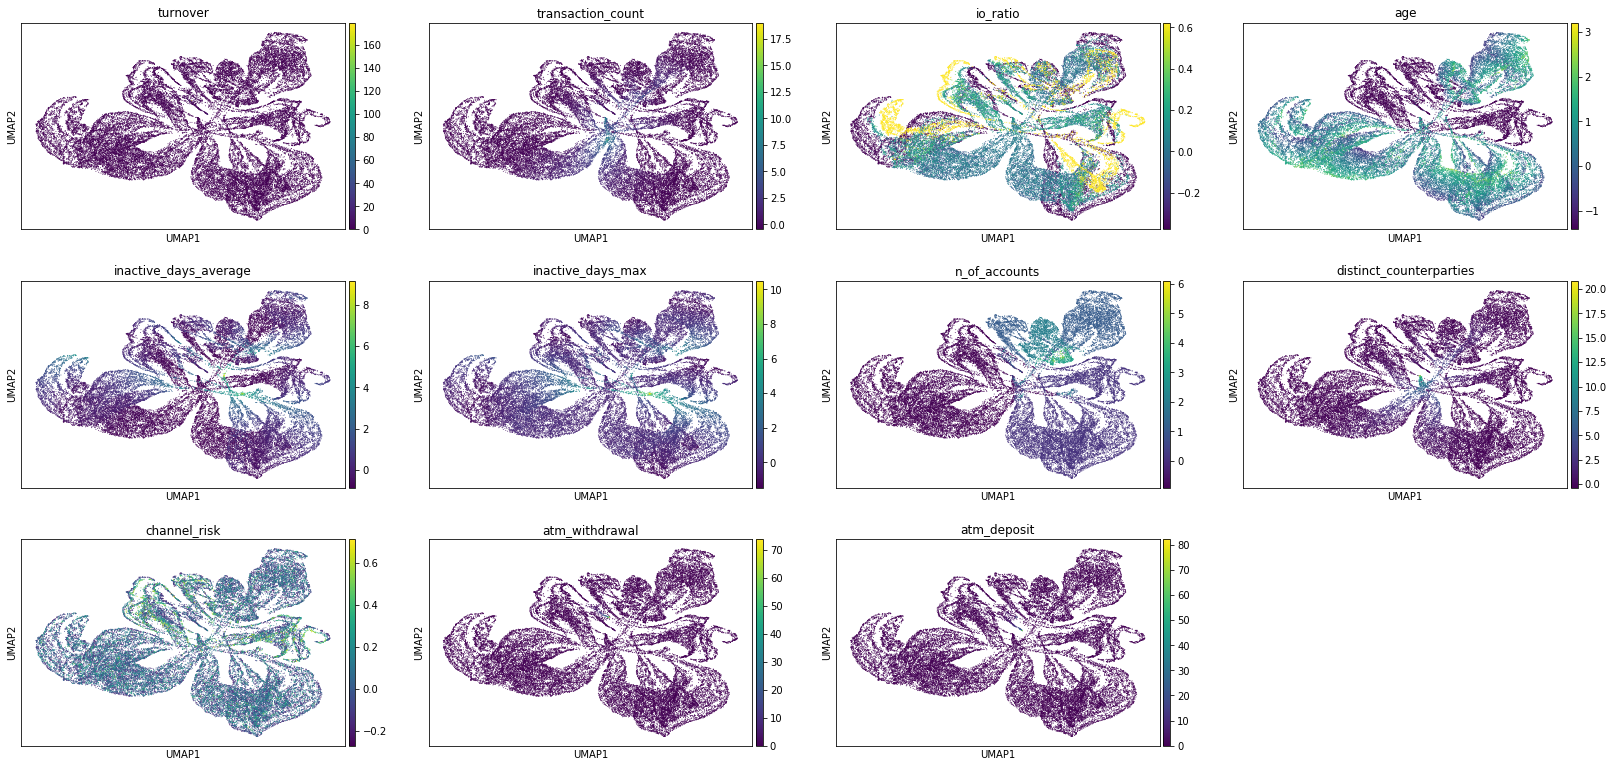

In [107]:
sc.pl.umap(adata, color=features)

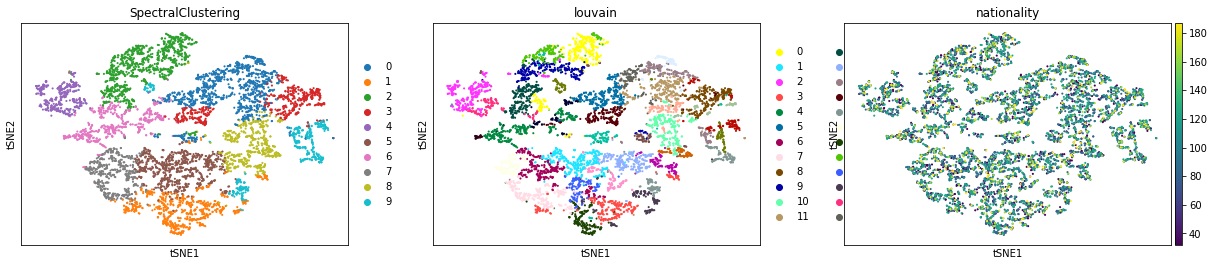

In [167]:
sc.pl.umap(adata, color=['SpectralClustering', 'louvain', 'nationality'])

In [100]:
df_adata = pd.DataFrame(X_core, columns=features)

/Users/klanna/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


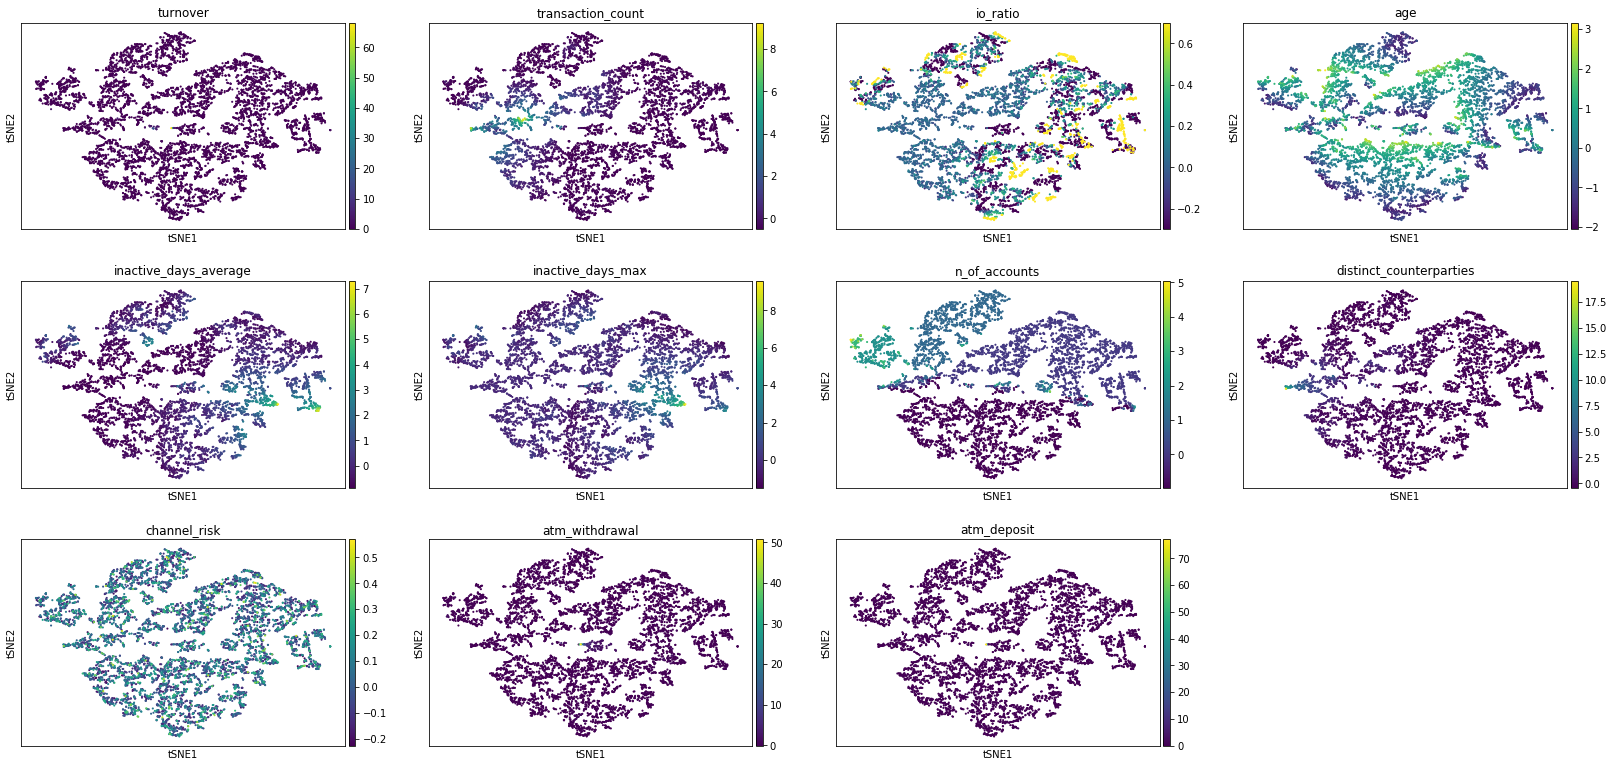

In [168]:
sc.pl.tsne(adata, color=features)

In [101]:
df_adata['louvain'] = np.array(adata.obs['louvain'])

In [178]:
idx = np.where(labels == 0)[0]
idx = random.sample(list(idx[np.where(df['category'].values[idx] == 0)[0]]), 20000)

In [179]:
X_core = df[features].values[idx, :]
Xm = np.mean(X_core, axis=0)
Xs = np.std(X_core, axis=0)
Xs[Xs < 1] = 1
X = (X_core - Xm)/Xs
np.std(X, axis=0)

adata = sc.AnnData(X)
adata.var_names = features

adata.obs['category'] = df['category'].values[idx]
adata.obs['nationality'] = df['nationality'].values[idx]
adata.obs['is_pep'] = df['is_pep'].values[idx]
adata.obs['labels'] = labels[idx]

sc.pp.neighbors(adata, n_neighbors=35)

sc.tl.umap(adata)

sc.tl.louvain(adata, resolution=0.99)

In [180]:
df_adata = pd.DataFrame(X_core, columns=features)

In [181]:
from sklearn.cluster import SpectralClustering

adata.obs['spectral'] = [str(i) for i in SpectralClustering(affinity='nearest_neighbors', 
                                                            n_clusters=3, n_init=10, n_jobs=None,
          n_neighbors=30, random_state=0).fit(X).labels_]


In [182]:
df_adata['louvain'] = np.array(adata.obs['louvain'])
df_adata.groupby('louvain').mean().reset_index(False)

louvain      turnover  transaction_count  io_ratio        age  \
0        0  7.574508e+05           3.012821  0.274060  28.386752   
1        1  7.335536e+05          67.282276  0.303119  49.117615   
2       10  6.169835e+05           1.228484  0.264088  46.313525   
3       11  7.795248e+05          51.486486  0.302508  28.170388   
4       12  5.786360e+05           1.166253  0.295285  49.769231   
5       13  5.508250e+05           2.879690  0.465284  62.294955   
6       14  7.199919e+05           4.227334  0.270642  25.382950   
7       15  1.272050e+06         202.814925  0.301862  42.877612   
8       16  7.536834e+05           1.192225  0.319294  45.181425   
9       17  2.152929e+07          27.610294  0.291421  47.466912   
10      18  7.918982e+06           1.987552  0.000754  48.759336   
11       2  6.981269e+05           4.177033  0.344701  61.400547   
12       3  6.273298e+05           2.889044  0.333185  54.662247   
13       4  7.560820e+05           9.555868  0.311861  27.147576   
14       5  7.895440e+05           3.508734  0.281835  56.529112   
15       6  7.304602e+05          19.495413  0.294485  46.333333   
16       7  6.352519e+05           2.248068  0.276390  42.268161   
17       8  6.826547e+05          73.126351  0.302939  57.287614   
18       9  7.821534e+05          65.499505  0.300480  44.837784   

    inactive_days_average  inactive_days_max  n_of_accounts  \
0               47.296277         102.160791       1.000000   
1                5.619639          94.743982       2.012582   
2              113.757008         114.317623       2.306352   
3                5.349119          96.057579       1.000000   
4              140.901092         141.401985       1.124069   
5               28.788344          50.802070       1.000000   
6               42.395115          88.577808       3.001353   
7                1.088015          93.153731       1.988060   
8              205.399222         426.280778       2.138229   
9               27.509228          96.797794       2.062500   
10              61.349087         112.228216       1.854772   
11              30.421107          72.713602       2.000000   
12              56.961417         126.256804       3.006978   
13              25.314694          73.314125       2.000000   
14              61.681849         161.139010       1.000000   
15              35.811170         101.751529       4.323394   
16              78.300162         185.294436       2.001546   
17               3.866027          93.134663       1.000000   
18               4.414214          94.579624       3.036597   

    distinct_counterparties  channel_risk  atm_withdrawal    atm_deposit  
0                  1.247329      0.228820    1.425718e+05    2789.736667  
1                 10.876915      0.233314    3.336591e+04    2721.461166  
2                  1.012295      0.224862    1.553355e+05    2358.707603  
3                  8.099882      0.224701    3.216283e+04    3329.032847  
4                  1.011166      0.235681    1.541213e+05    2189.417963  
5                  1.230272      0.230050    5.635469e+04    1648.098350  
6                  1.331529      0.225189    1.049763e+05    3202.989320  
7                 64.332836      0.234156    4.447513e+04    4408.067390  
8                  1.021598      0.224305    2.117397e+05    2597.024867  
9                  4.764706      0.231055    4.572510e+05  128510.926856  
10                 1.174274      0.227217    7.903985e+06   45281.959030  
11                 1.477102      0.226510    1.035788e+05    2233.683614  
12                 1.243545      0.229659    9.924884e+04    2180.812019  
13                 2.118060      0.234556    9.260426e+04    2655.524947  
14                 1.291121      0.231245    1.049350e+05    2861.324091  
15                 3.631498      0.227306    1.043753e+05    3047.076763  
16                 1.141422      0.239718    1.332759e+05    2450.168944  
17                12.013300    

In [183]:
df_adata['spectral'] = np.array(adata.obs['spectral'])
df_adata.groupby('spectral').mean().reset_index(False)

spectral      turnover  transaction_count  io_ratio        age  \
0        0  8.783388e+05          39.126730  0.300501  45.453387   
1        1  1.046508e+06          23.109079  0.301819  45.318897   
2        2  1.312065e+06          21.056553  0.302415  45.365474   

   inactive_days_average  inactive_days_max  n_of_accounts  \
0              40.934104         111.753642       3.283503   
1              50.858808         121.675454       1.031338   
2              42.538035         108.124417       2.000848   

   distinct_counterparties  channel_risk  atm_withdrawal  atm_deposit  
0                10.462127      0.228633   132829.940437  3454.505648  
1                 4.457700      0.231571   312951.438245  5127.200674  
2                 4.035204      0.232105   112850.198752  5856.230665

... storing 'spectral' as categorical


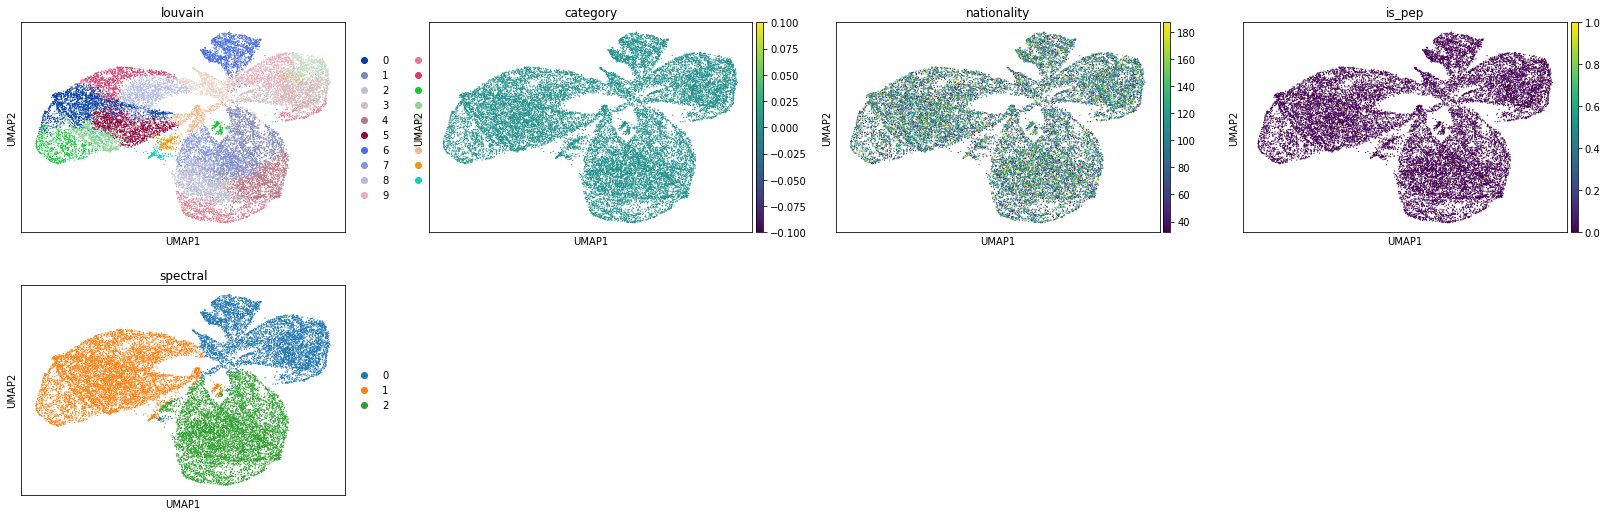

In [184]:
sc.pl.umap(adata, color=['louvain', 'category', 'nationality', 'is_pep', 'spectral'])

/Users/klanna/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


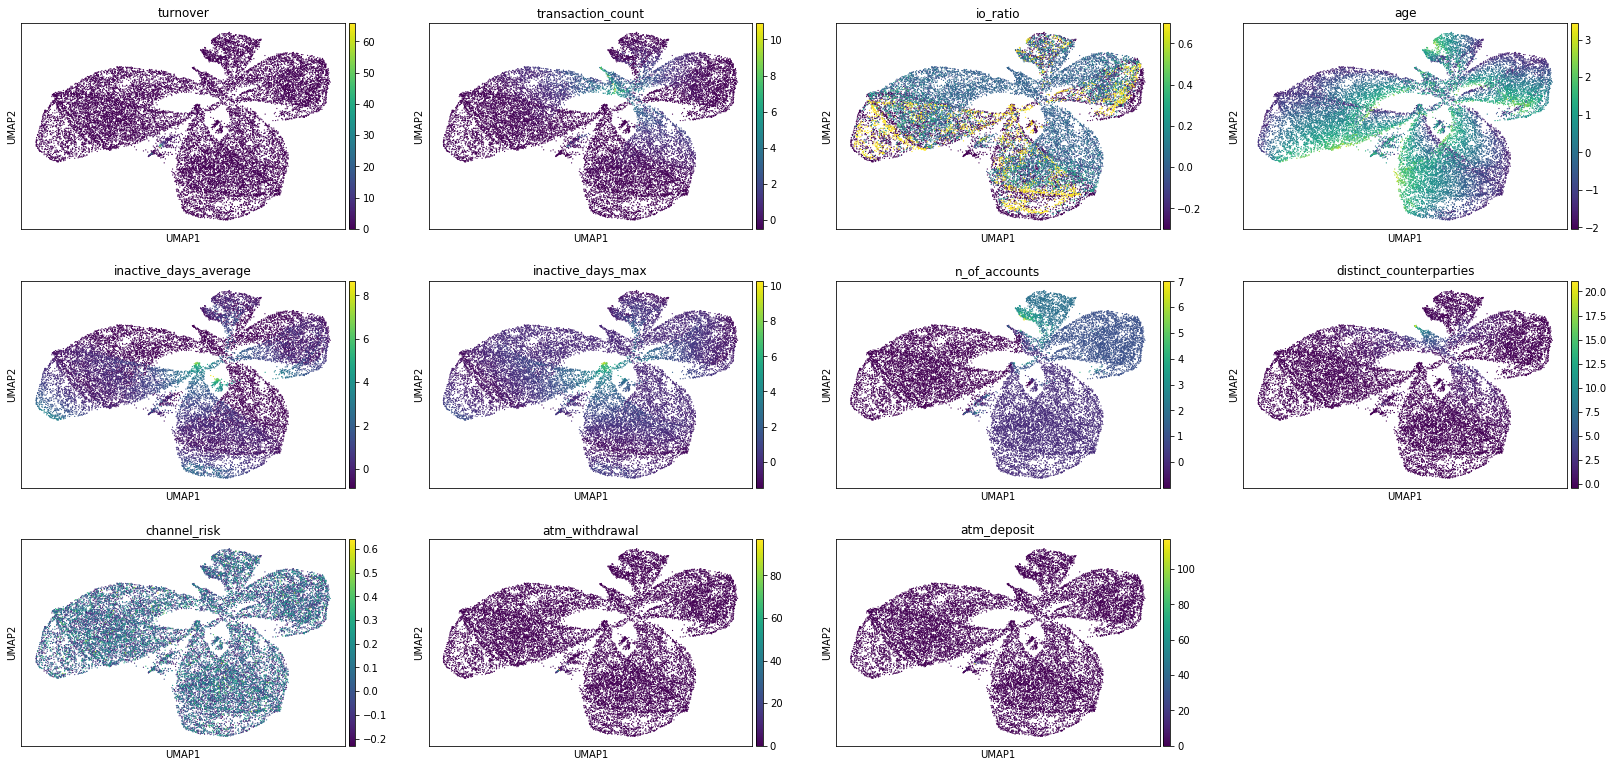

In [185]:
sc.pl.umap(adata, color=features)